In [2]:
#Primero de todo vamos a importar las librerias necesarias para realizar el EDA de
#Airbnb nova york
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump


PASO 1: RECOLECCIÓN DE DATOS.

In [3]:
from sklearn.utils import shuffle
#Cargamos el csv via URL o pathing de nuestro repositorio
#y lo guardamos en una variable tipo dataframe
df_rawdata = pd.DataFrame(pd.read_csv("/workspaces/JBGEDA1/data/raw/AB_NYC_2019.csv"))

PASO 2: EXPLORACION Y LIMPIEZA DE DATOS

In [4]:
#Creamos una variable para que contenga una tupla, para saber
#las dimensiones de nuestro dataframe
dimensions = df_rawdata.shape
#El .info() nos dara informacion basica de nuestro dataframe
df_rawdata.info()
print("dimensions")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Hacemos un breve analisis de nuestros datos (variables) por columnas.


In [5]:
#Eliminamos las columnas que no nos interese para correlacionar
#con nuestra variable target
df_rawdata.drop(['name','host_name','id', 'host_id','last_review'], inplace=True, axis=1)
#Podemos calcular la cantidad de nulls por columna, es decir datos
#erróneos o no insertados al indice
nulls = df_rawdata.isnull().sum()
#Printeamos nulls por consola
print(nulls)

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


NUESTRO TARGET , evidentemente sera el PRECIO DE ALQUILER por servicios de las viviendas de airbnb en Nueva York.

['reviews_per_month''] tendremos que rellenarla  con la moda, en el caso que no haya una tendencia repetida, que es este precisamente, bajo mi criterio, rellenare los NaNs con la mediana, ya que puede haber outliers que nos distorsionen demasiado la media, en este caso es lo que ocurre.
Bajo mi perspectiva latitud y longitud es informacion redundante, informacion que ya nos aporta los barrios y los grupos de barrios. Podemos eliminar esas variables numericas.

In [6]:
#Volvemos a eliminar columnas del DF.
#Para Visualizar que se ha eliminado
#podemos printear de nuevo el null
nulls = df_rawdata.isnull().sum()
#Printeamos nulls por consola
print(nulls)
df_rawdata.head(4)

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194


In [7]:
#Realizaremos un info para ver ciertas cualidades de las columnas y ver que se han eliminado algunas.
df_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [8]:
#La columna de reviews_per_month sera poco relevante así que he decidido rellenar los datos faltantes
#como si de una categórica sin importancia se tratase, decido usar la moda para rellenar datos,
#aun así podria ser importante ya que al haber mas reviews hay muchos clientes necesitan
#informacion para coger la confianza al usar X servicios.
df_rawdata['reviews_per_month'] = df_rawdata['reviews_per_month'].fillna(df_rawdata['reviews_per_month'].median())
df_rawdata.head(4)
#Nos aseguramos que los datos de NA en ['reviews_per_month'] se han modificado.

    


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.72,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194


Observando el dataset de forma general, nos hacemos una idea de las principales variables que afectan
al precio, aun así listaremos todas las columnas/variables en orden de aparición:

neighbourhood_group: variable categórica.
neighbourhood: var cat.
room_type: var cat.
price: var Numérica. Nuestra Var target.
minimum_nights: var num.
number_of_reviews: var num.
reviews_per_month: var num.
calculated_host_listings_count: var num.
availability_365: var num.

Un total de 3 variables categóricas relevantes.
Un total de 6 variables numéricas.
En total 9 variables relevantes en el estudio.


    

PASO 3: ANÁLISIS VARIABLES UNIVARIADAS.
3.1) VARIABLES CATEGÓRICAS.

,Barrios,MuestrasBarrios
0,Williamsburg,3920
1,Bedford-Stuyvesant,3714
2,Harlem,2658
3,Bushwick,2465
4,Upper West Side,1971
...,...,...
216,Richmondtown,1
217,Fort Wadsworth,1
218,New Dorp,1
219,Rossville,1


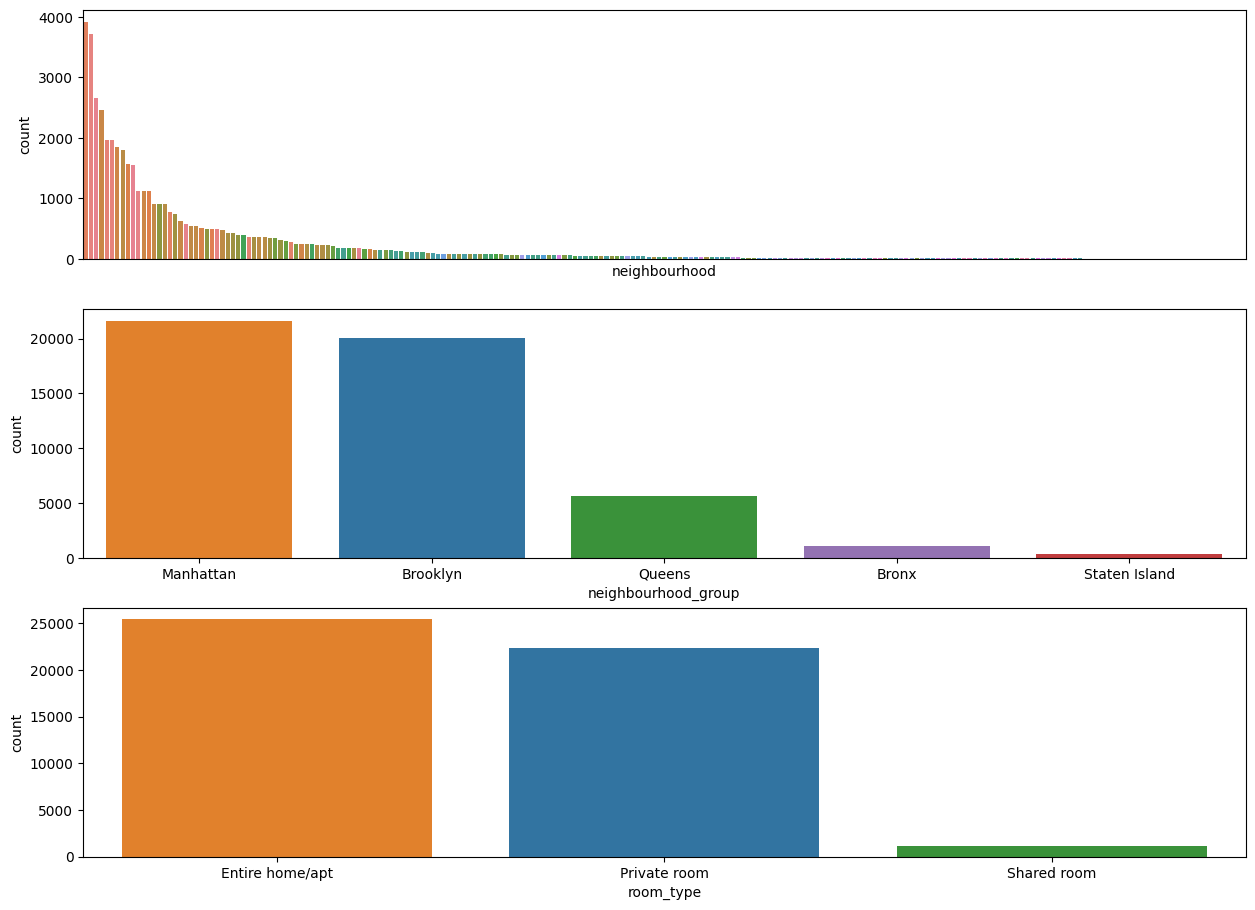

In [9]:
#VARIABLES CATEGÓRICAS.
fig, axis = plt.subplots(3, 1, figsize = (15, 11))
#Creamos 3 subgraficos en el conjunto,['room_types'], ['neighbourhood'] y ['neighbourhood_group'], analizando la cantidad de veces que aparece
#una variable categorica y sacar conclusiones. Es decir el eje Y de cada subplot sera la cantidad y el 
#eje x seran los valores categoricos de una columna, ordenandolo por orden de aparicion en el indice.
sns.countplot(ax = axis[0],
              data = df_rawdata,
              x = "neighbourhood",
              hue = "neighbourhood",
              order=df_rawdata['neighbourhood'].sort_values().value_counts().index).set_xticks([])
#Con .set_xticks([]) suprimimos la aparicion descriptiva para cada punto de X. 
sns.countplot(ax = axis[1],
              data = df_rawdata,
              x = "neighbourhood_group",
              hue = "neighbourhood_group",
              order=df_rawdata['neighbourhood_group'].sort_values().value_counts().index)
# Crear el gráfico de conteo
sns.countplot(ax=axis[2],
              data=df_rawdata,
              x="room_type",
              hue="room_type",
              order=df_rawdata['room_type'].sort_values().value_counts().index)
#Por si queremos analizar el conteo por barrios para una evaluación mas
#detallada guardamos en un dataframe exclusivo para sacar cálculos de los
#barrios.
counts = df_rawdata['neighbourhood'].value_counts()
neighborhoods = pd.DataFrame({'counts.index': counts.index, 'counts': counts.values})
neighborhoods.columns = ['Barrios', 'MuestrasBarrios']
neighborhoods



In [10]:
# Realizaremos los tipos de porcentajes por tipo de servicio para entender las tendencias de los clientes.
entirepercent = ((df_rawdata["room_type"].value_counts()["Entire home/apt"]) / df_rawdata["room_type"].count()) * 100
privpercent = ((df_rawdata["room_type"].value_counts()["Private room"]) / df_rawdata["room_type"].count()) * 100
sharedpercent = ((df_rawdata["room_type"].value_counts()["Shared room"]) / df_rawdata["room_type"].count()) * 100
print('El porcentaje de alquileres de vivienda completa són:',entirepercent,'%')
print('El porcentaje de alquileres de habitación privada:',privpercent,'%')
print('El porcentaje de alquileres de habitación compartida són:',sharedpercent,'%')

El porcentaje de alquileres de vivienda completa són: 51.96645873811229 %
El porcentaje de alquileres de habitación privada: 45.661110543000305 %
El porcentaje de alquileres de habitación compartida són: 2.372430718887412 %


In [11]:
#Ahora hecharemos un vistazo la preferencia de los usuarios a la hora de escoger localización. Nos fijaremos
#por las localizaciones a nivel geografico mas que por distritos.
manhattan100 = ((df_rawdata["neighbourhood_group"].value_counts()["Manhattan"]) / df_rawdata["neighbourhood_group"].count()) * 100
Brooklyn100  = ((df_rawdata["neighbourhood_group"].value_counts()["Brooklyn"]) / df_rawdata["neighbourhood_group"].count()) * 100
Queens100 = ((df_rawdata["neighbourhood_group"].value_counts()["Queens"]) / df_rawdata["neighbourhood_group"].count()) * 100
Bronx100 = ((df_rawdata["neighbourhood_group"].value_counts()["Bronx"]) / df_rawdata["neighbourhood_group"].count()) * 100
StatenIsland100 = ((df_rawdata["neighbourhood_group"].value_counts()["Staten Island"]) / df_rawdata["neighbourhood_group"].count()) * 100
print('Manhattan:', manhattan100, '%','\n', 'Brooklyn:', Brooklyn100, '%','\n', 'Queens:', Queens100, '%','\n', 'Bronx:', Bronx100, '%','\n', 'Staten Island:', StatenIsland100, '%','\n')

Manhattan: 44.30105327743123 % 
 Brooklyn: 41.11667859699356 % 
 Queens: 11.588096942427653 % 
 Bronx: 2.231311995091523 % 
 Staten Island: 0.7628591880560385 % 



COMO CONCLUSIONES DE NUESTRAS VARIABLES CATEGÓRICAS PODEMOS AFIRMAR QUE CASI TODOS LOS CLIENTES DE AIR BNB PREFIEREN ALQUILAR APARTAMENTOS ENTEROS O HABITACIONES PRIVADAS EN MANHATTAN Y BROOKLYN. UNA DECIMA PARTE APROXIMADAMENTE EN QUEENS, Y MENOS DE UN 3% EN BRONX Y STATEN ISLAND. EL TIPO DE ALQUILER POR HABITACIÓN COMPARTIDA ES RESIDUAL.

PASO 3: ANÁLISIS VARIABLES UNIVARIADAS.
3.1) VARIABLES NUMÉRICAS.

In [ ]:

#Preparo los datos para graficar.(EJEX)
maxpricegraph= df_rawdata['price'].max()
maxpricegraph
maxmngraph= df_rawdata['minimum_nights'].max()
maxnorgraph= df_rawdata['number_of_reviews'].max()
maxrpmgraph= df_rawdata['reviews_per_month'].max()
maxchlgraph= df_rawdata['calculated_host_listings_count'].max()
maxa3graph= df_rawdata['availability_365'].max()

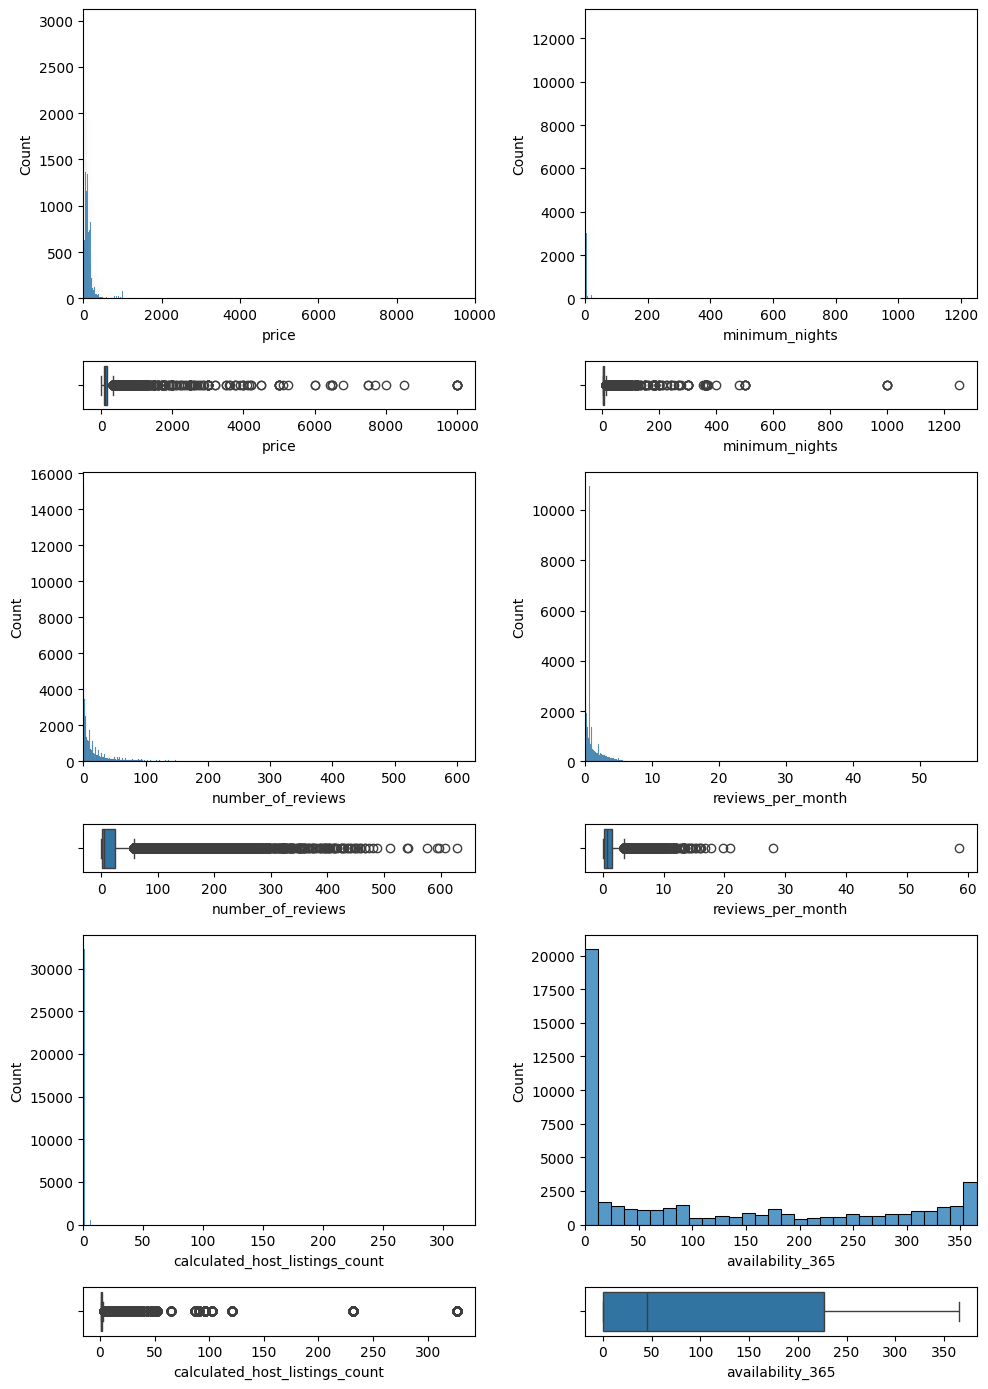

In [27]:
'''
price: var num.
minimum_nights: var num
number_of_reviews: var num.
reviews_per_month: var num.
calculated_host_listings_count: var num.
availability_365: var num.'''

fig, axis = plt.subplots(6,2, figsize=(10,14),
                         gridspec_kw={"height_ratios":[6,1,6,1,6,1]})
#CON EL PARAMETRO ANTERIOR GRID... DAMOS FORMATO RELATIVAMENTE,
#TENIENDO EN CUENTA SOLO LA ALTURA(height, tambien podemos usar weight) Y POR ORDEN DE FILAS,
#LOS GRAFICOS DE CAJA(filas pares) SON 6 VECES MENOR A LOS HISTOGRAMAS(filas del subplot inpares).
#varnum price
sns.histplot(ax= axis[0,0], data=df_rawdata, x="price").set_xlim(0, maxpricegraph)
sns.boxplot(ax=axis[1,0], data=df_rawdata, x="price")
#varnum minimum_nights
sns.histplot(ax= axis[0,1], data=df_rawdata, x="minimum_nights").set_xlim(0, maxmngraph)
sns.boxplot(ax= axis[1,1], data=df_rawdata, x="minimum_nights")
#varnum number_of_reviews
sns.histplot(ax= axis[2,0], data=df_rawdata, x="number_of_reviews").set_xlim(0, maxnorgraph)
sns.boxplot(ax= axis[3,0], data=df_rawdata, x="number_of_reviews")
#varnum reviews_per_month
sns.histplot(ax= axis[2,1], data=df_rawdata, x="reviews_per_month").set_xlim(0, maxrpmgraph)
sns.boxplot(ax= axis[3,1], data=df_rawdata, x="reviews_per_month")
#varnum calculated_host_listings_count
sns.histplot(ax= axis[4,0], data=df_rawdata, x="calculated_host_listings_count").set_xlim(0, maxchlgraph)
sns.boxplot(ax= axis[5,0], data=df_rawdata, x="calculated_host_listings_count")
#varnum availability_365
sns.histplot(ax= axis[4,1], data=df_rawdata, x="availability_365").set_xlim(0, maxa3graph)
sns.boxplot(ax= axis[5,1], data=df_rawdata, x="availability_365")
plt.tight_layout()
plt.show()